In [1]:
import xarray as xr
import numpy as np
from datetime import datetime
from calendar import monthrange
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import random
from datetime import datetime
import metpy
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 13
})

/opt/miniconda3/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
def load_hens(initial_time):
    path = f"/pscratch/sd/a/amahesh/hens_copy/HENS_summer23_{initial_time:%Y%m%d}T000000/"
    ds = xr.open_mfdataset(f"{path}/ensemble_out_*nc", concat_dim='ensemble', combine='nested', parallel=False,
                           group='global', coords='minimal', compat='override',
                          data_vars=['t2m', 'd2m'])
    year, month, day = initial_time.year, initial_time.month, initial_time.day
    root = f"/pscratch/sd/a/amahesh/hens_copy/HENS_summer23_{initial_time:%Y%m%d}T000000/ensemble_out_07400_{year}-{month:02d}-{day:02d}-00-00-00.nc"
    ds['time'] = xr.open_dataset(root)['time']
    return ds

def load_hens(initial_time):
    path = f"/pscratch/sd/a/amahesh/hens_copy/HENS_summer23_{initial_time:%Y%m%d}T000000/"
    ds = xr.open_mfdataset(f"{path}/ensemble_out_*nc", concat_dim='ensemble', combine='nested', parallel=False,
                           group='global', coords='minimal', compat='override',
                          data_vars=['t2m', 'd2m'])
    year, month, day = initial_time.year, initial_time.month, initial_time.day
    root = f"/pscratch/sd/a/amahesh/hens_copy/HENS_summer23_{initial_time:%Y%m%d}T000000/ensemble_out_07400_{year}-{month:02d}-{day:02d}-00-00-00.nc"
    ds['time'] = xr.open_dataset(root)['time']
    return ds

def load_ens(initial_time, ens):
    path = f"/pscratch/sd/a/amahesh/hens_copy/HENS_summer23_{initial_time:%Y%m%d}T000000/"
    year, month, day = initial_time.year, initial_time.month, initial_time.day
    ds = xr.open_dataset(f"{path}/ensemble_out_{ens:05d}_{year}-{month:02d}-{day:02d}-00-00-00.nc",
                        group='global')[['d2m', 't2m']]
    
    root = f"/pscratch/sd/a/amahesh/hens_copy/HENS_summer23_{initial_time:%Y%m%d}T000000/ensemble_out_07400_{year}-{month:02d}-{day:02d}-00-00-00.nc"
    ds['time'] = xr.open_dataset(root)['time']
    return ds
# ds = load_hens(datetime(2023,8,13))

    

In [3]:
kc_forecast_init = xr.open_mfdataset("/pscratch/sd/a/amahesh/hens/kansascity_demo/*nc",
                                           combine='nested', concat_dim='initial_time')
initial_times =  pd.date_range(start='2023-08-09', end='2023-08-23', freq='D')
kc_forecast_init['initial_time'] = initial_times

kc_ens = kc_forecast_init.sel(initial_time='2023-08-14T00:00:00')
kc_lat, kc_lon = 39, 360-94.5

In [4]:
ifs = xr.open_dataset("/pscratch/sd/a/amahesh/tigge/d2m_t2m_summer23/sfc/sfcvars__ens_2023_08_13_raw.grib")
ifs = ifs.sel(time='2023-08-14T00:00:00').rename({'latitude' : 'lat', 
                                                  'longitude' : 'lon'})
ifs = ifs.sel(step=np.timedelta64(234, 'h'))
ifs_hw = ifs.sel(lat=kc_lat, lon=kc_lon)

In [5]:
true = xr.open_dataset("/pscratch/sd/p/pharring/74var-6hourly/staging/2023.h5", mode='r')
dummy = xr.open_dataset("/dvs_ro/cfs/cdirs/m1517/cascade/amahesh/hens/HENS_summer23_20230814T000000/ensemble_out_00001_2023-08-14-00-00-00.nc",
                       group='global')

true = true.rename({'phony_dim_0' : 'time',
                    'phony_dim_2' : 'lat', 
             'phony_dim_3' : 'lon',
             'phony_dim_1' : 'channel'})
true['lat'] = dummy['lat']
true['lon'] = dummy['lon']
true['channel'] = ["u10m", "v10m", "u100m", "v100m", "t2m", "sp", "msl", "tcwv", "d2m", "u50", "u100", "u150", "u200", "u250", "u300", "u400", "u500", "u600", "u700", "u850", "u925", "u1000", "v50", "v100", "v150", "v200", "v250", "v300", "v400", "v500", "v600", "v700", "v850", "v925", "v1000", "z50", "z100", "z150", "z200", "z250", "z300", "z400", "z500", "z600", "z700", "z850", "z925", "z1000", "t50", "t100", "t150", "t200", "t250", "t300", "t400", "t500", "t600", "t700", "t850", "t925", "t1000", "q50", "q100", "q150", "q200", "q250", "q300", "q400", "q500", "q600", "q700", "q850", "q925", "q1000"]
true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')

/tmp/ipykernel_61203/3307059350.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


In [6]:
true_kc = true.sel(lat=kc_lat, lon=kc_lon,
                   time='2023-08-23T18:00:00', channel=['t2m', 'd2m'])

In [7]:
true_kc = true_kc['fields'].to_dataset("channel")

In [8]:
true_kc['t2m'].values, true_kc['d2m'].values

(array(307.9494, dtype=float32), array(297.98413, dtype=float32))

In [9]:
analysis = xr.open_dataset("/pscratch/sd/a/amahesh/tigge/analysis/ifs_analysis-2023-08.grib")
analysis = analysis[['t2m', 'd2m']].sel(time='2023-08-23T18:00:00').rename({'latitude' : 'lat', 
                                                  'longitude' : 'lon'})
analysis = analysis.sel(lat=kc_lat, lon=kc_lat)

In [10]:
analysis['t2m'].values, analysis['d2m'].values

(array(308.36273, dtype=float32), array(297.97913, dtype=float32))

In [12]:
ifs_boxwhisker = []
day = 7
for initial_time in initial_times:
    if (initial_time.day - 10) % 3 == 0:
        day = initial_time.day
    ifs = xr.open_dataset(f"/pscratch/sd/a/amahesh/tigge/d2m_t2m_summer23/sfc/sfcvars__ens_2023_08_{day:02d}_raw.grib")
    ifs = ifs.sel(time=initial_time).rename({'latitude' : 'lat', 
                                                      'longitude' : 'lon'})
    ifs['step'] = ifs['step'] + initial_time
    ifs = ifs.sel(step='2023-08-23T18:00:00')
    ifs_boxwhisker.append(ifs.sel(lat=kc_lat, lon=kc_lon)[['d2m','t2m']].load())
ifs_boxwhisker = xr.concat(ifs_boxwhisker, dim = 'initial_time')

In [11]:
climatology = xr.open_zarr("/pscratch/sd/a/amahesh/hens/thresholds/t2m_mean_08_18/")
climatology = climatology.sel(latitude=kc_lat, longitude=kc_lon)
percentile = xr.open_zarr("/pscratch/sd/a/amahesh/hens/thresholds/t2m_percentile95_08_18/")
percentile = percentile.sel(latitude=kc_lat, longitude=kc_lon)


In [12]:
percentile['VAR_2T'].values

array(307.60263977)

/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


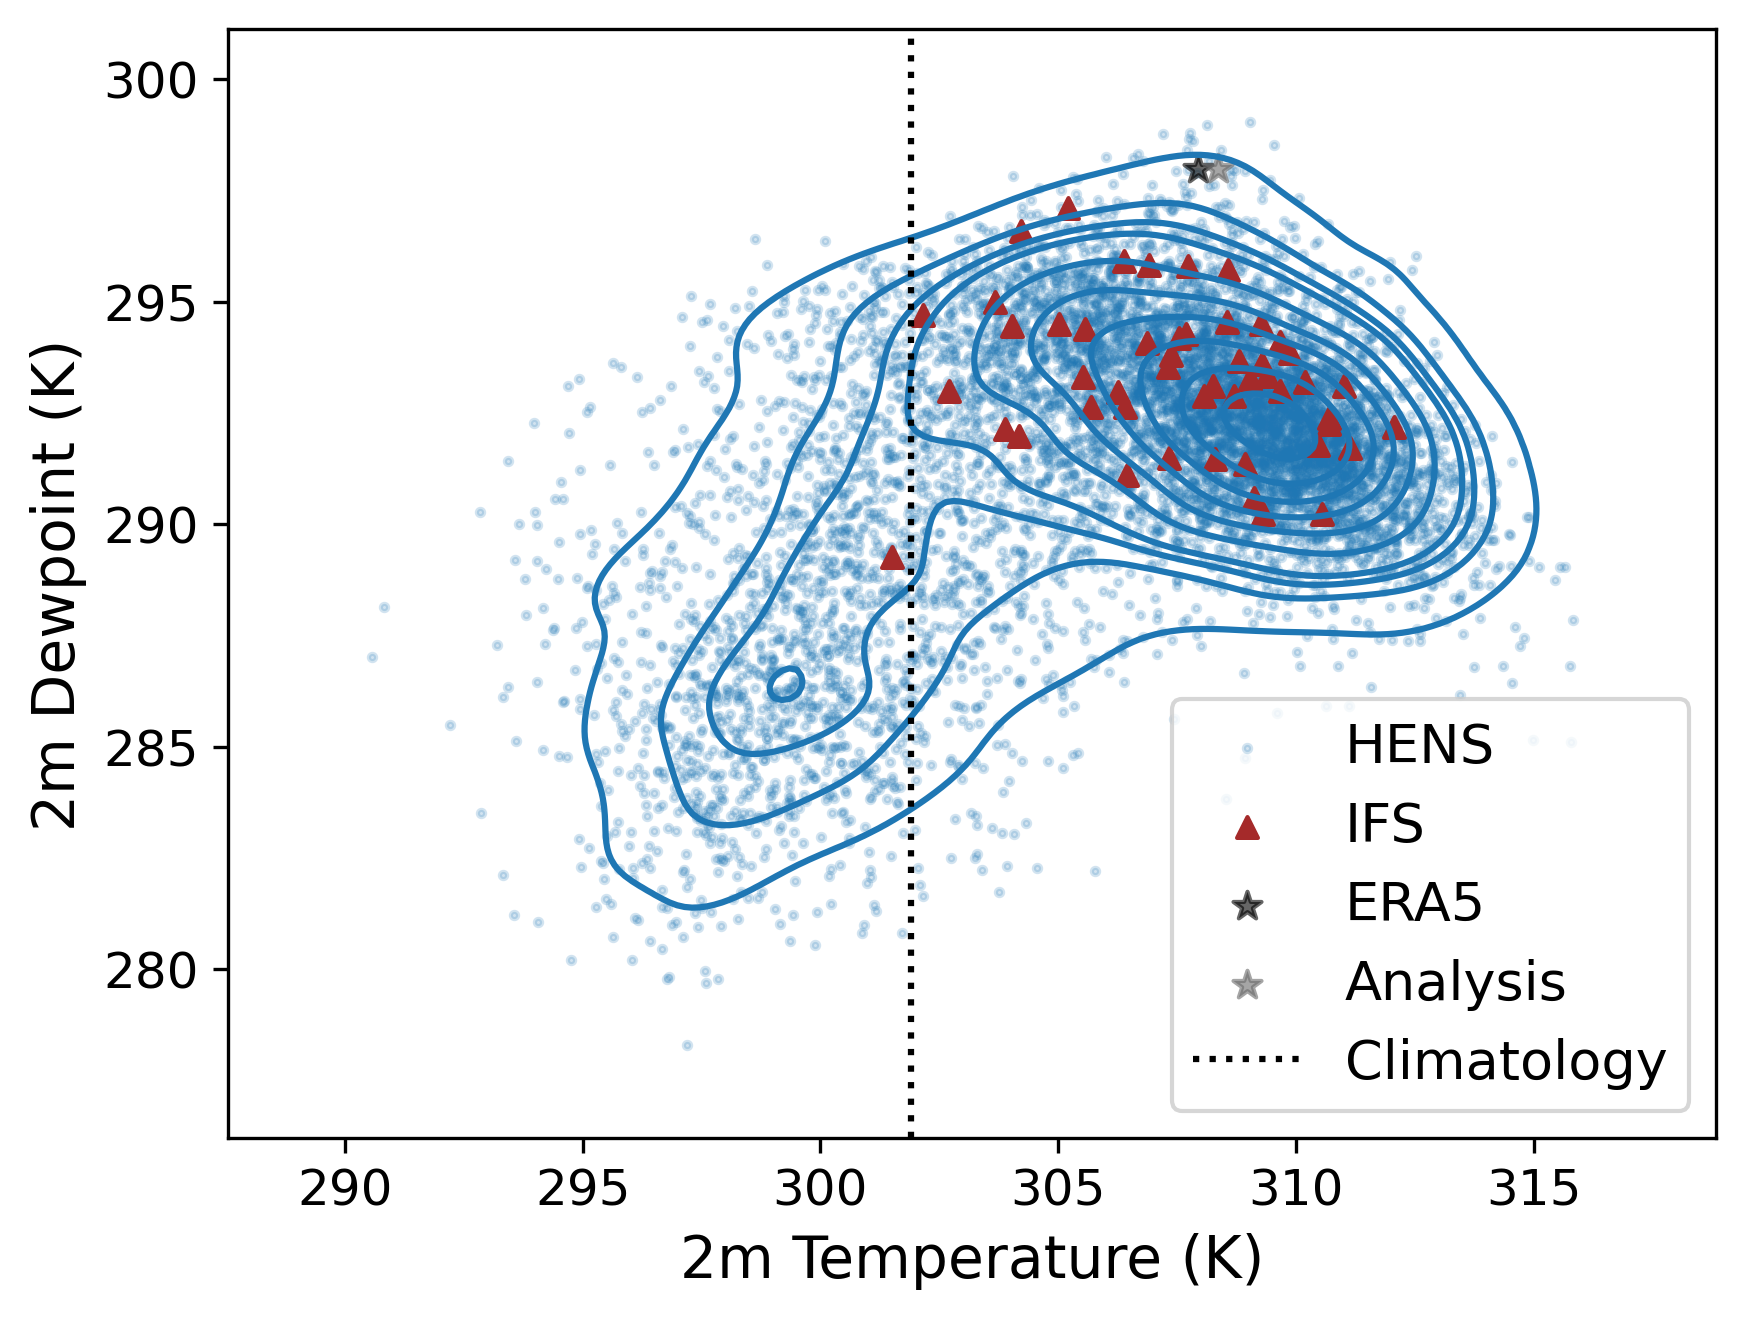

In [14]:
import seaborn as sns
plt.figure(dpi=300)
plt.xlabel("2m Temperature (K)")
plt.ylabel("2m Dewpoint (K)")
plt.scatter(kc_ens['t2m'],
            kc_ens['d2m'], s=3, alpha=0.2, label='HENS')

sns.kdeplot(data=kc_ens, x='t2m', y='d2m', 
           linewidth=2, levels=np.arange(0.05, 0.96, 0.1))
plt.scatter(ifs_hw['t2m'], ifs_hw['d2m'], marker='^', s=25, color='brown', label='IFS')
plt.scatter(true_kc['t2m'], true_kc['d2m'], s=50, marker='*', alpha=0.6, 
            color='black', label='ERA5')
plt.scatter(analysis['t2m'], analysis['d2m'], s=50, marker='*', alpha=0.6, label='Analysis',
           color='dimgray')
plt.axvline(climatology['VAR_2T'], linestyle='dotted', color='black', label='Climatology')

plt.legend()


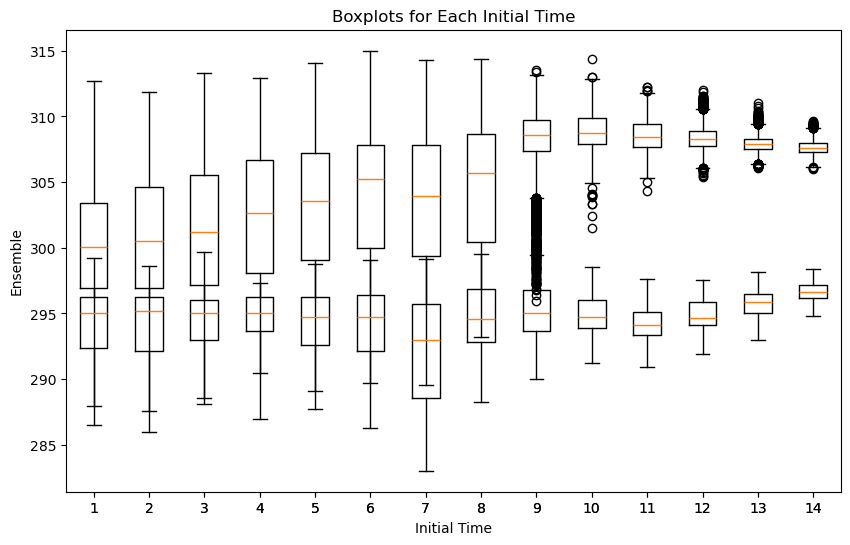

In [12]:
# Plotting boxplots for each initial time on one plot
plt.figure(figsize=(10, 6))
plt.boxplot(kc_forecast_init['t2m'].values.T, showfliers=True)
plt.boxplot(ifs_boxwhisker['d2m'].values.T, showfliers=False)

plt.title('Boxplots for Each Initial Time')
plt.xlabel('Initial Time')
plt.ylabel('Ensemble')
plt.show()


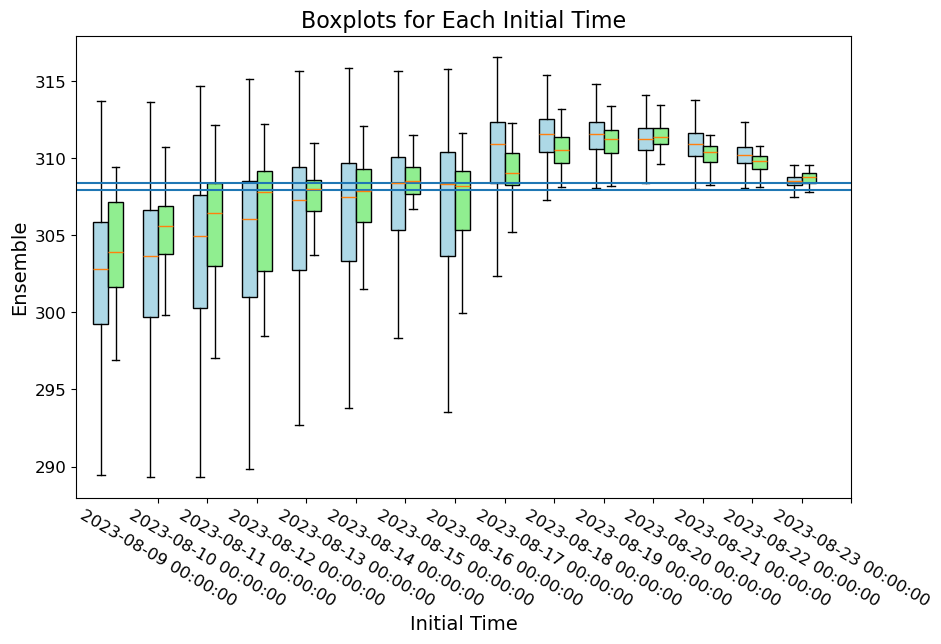

In [20]:
import matplotlib.pyplot as plt
import numpy as np


# Create a figure
plt.figure(figsize=(10, 6))

# Plot the first set of boxplots
plt.boxplot(kc_forecast_init['t2m'].T, positions=np.arange(15) - 0.15, widths=0.3, showfliers=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))

# Plot the second set of boxplots
plt.boxplot(ifs_boxwhisker['t2m'].T, positions=np.arange(15) + 0.15, widths=0.3, showfliers=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Adding labels and title
plt.title('Boxplots for Each Initial Time')
plt.xlabel('Initial Time')
plt.ylabel('Ensemble')
plt.xticks(np.arange(1,16), labels=initial_times, rotation=330)
plt.axhline(true_kc['t2m'].values)
plt.axhline(analysis['t2m'].values)

# Show the plot
plt.show()


In [36]:
lookup_table = xr.open_zarr("/pscratch/sd/a/amahesh/hens/highres_heat_index_lookup.zarr")


In [37]:
def _saturation_vapor_pressure(temperature):
        """
        temperature must be in units of Kelvin
        """
        sat_pressure_0c = 6.112
        return sat_pressure_0c * np.exp(17.67 * (temperature - 273.15) / (temperature - 29.65))

def _calculate_rh_from_dewpoint(t2m, d2m):
    """
    t2m: temperature at 2m in Kelvin
    d2m: dewpoint at 2m in Kelvin
    """
    sat_vapor_pressure = _saturation_vapor_pressure(t2m)
    vapor_pressure = _saturation_vapor_pressure(d2m)
    return vapor_pressure / sat_vapor_pressure

ifs_boxwhisker['rh'] = _calculate_rh_from_dewpoint(ifs_boxwhisker['t2m'], ifs_boxwhisker['d2m'])

NameError: name 'ifs_boxwhisker' is not defined

In [38]:
era5_rh = _calculate_rh_from_dewpoint(true_kc['t2m'], true_kc['d2m'])

In [40]:
analysis_rh = _calculate_rh_from_dewpoint(analysis['t2m'], analysis['d2m'])

In [41]:
lookup_table['heat_index'].sel(Rh=era5_rh, Ta=true_kc['t2m'], method='nearest').values

array(315.67733113)

In [19]:
lookup_table['heat_index'].sel(Rh=analysis_rh, Ta=analysis['t2m'], method='nearest').values

array(316.25313168)

In [20]:
ifs_boxwhisker['heat_index'] = lookup_table['heat_index'].sel(Rh=ifs_boxwhisker['rh'], Ta=ifs_boxwhisker['t2m'], method='nearest')

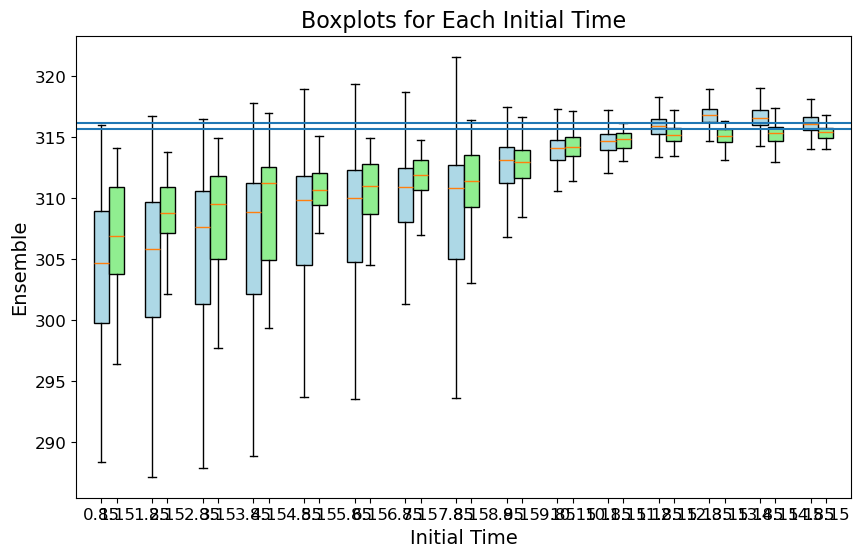

In [21]:
import matplotlib.pyplot as plt
import numpy as np


# Create a figure
plt.figure(figsize=(10, 6))

# Plot the first set of boxplots
plt.boxplot(kc_forecast_init['heat_index'].T, positions=np.arange(1,16) - 0.15, widths=0.3, showfliers=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))

# Plot the second set of boxplots
plt.boxplot(ifs_boxwhisker['heat_index'].T, positions=np.arange(1,16) + 0.15, widths=0.3, showfliers=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Adding labels and title
plt.title('Boxplots for Each Initial Time')
plt.xlabel('Initial Time')
plt.ylabel('Ensemble')
# plt.xticks(np.arange(1,16), labels=initial_times, rotation=330)
plt.xticks
plt.axhline(316.2)
plt.axhline(315.7)


# Show the plot
plt.show()


/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


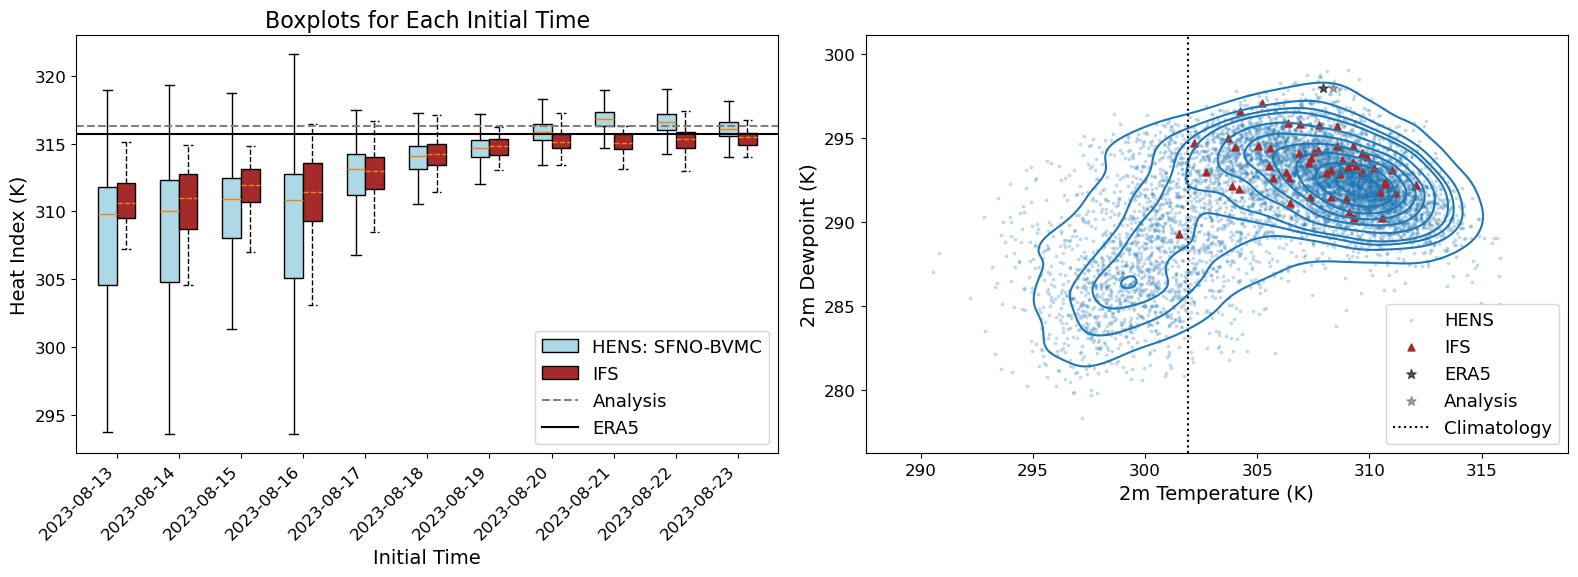

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Date range for initial times
initial_times = pd.date_range(start='2023-08-13', end='2023-08-23', freq='D')

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# First subplot: Boxplots
axs[0].boxplot(kc_forecast_init['heat_index'].T.sel(initial_time=slice('2023-08-13', '2023-08-23')), 
               positions=np.arange(1, 12) - 0.15, 
               widths=0.3, 
               showfliers=False, 
               patch_artist=True, 
               boxprops=dict(facecolor="lightblue", label='HENS: SFNO-BVMC'))

axs[0].boxplot(ifs_boxwhisker['heat_index'].T[:, 4:], 
               positions=np.arange(1, 12) + 0.15, 
               widths=0.3, 
               showfliers=False, 
               patch_artist=True, 
               boxprops=dict(facecolor="brown", linestyle="--", label='IFS'),
               whiskerprops=dict(linestyle='--'), 
               capprops=dict(linestyle='--'), 
               medianprops=dict(linestyle='--'))

axs[0].set_title('Boxplots for Each Initial Time')
axs[0].set_xlabel('Initial Time')
axs[0].set_ylabel('Heat Index (K)')
axs[0].set_xticks(np.arange(1, 12))
axs[0].set_xticklabels(initial_times.strftime('%Y-%m-%d'), rotation=45, ha='right')
axs[0].axhline(316.3, color='gray', label='Analysis', linestyle='--')
axs[0].axhline(315.7, color='black', label='ERA5')

# Adding legend to the first subplot
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0].legend(by_label.values(), by_label.keys())

# Second subplot: Scatter plot with KDE
sns.kdeplot(data=kc_ens, x='t2m', y='d2m', 
            linewidth=2, levels=np.arange(0.05, 0.96, 0.1), ax=axs[1])
axs[1].scatter(kc_ens['t2m'], kc_ens['d2m'], s=3, alpha=0.2, label='HENS')
axs[1].scatter(ifs_hw['t2m'], ifs_hw['d2m'], marker='^', s=25, color='brown', label='IFS')
axs[1].scatter(true_kc['t2m'], true_kc['d2m'], s=50, marker='*', alpha=0.6, 
               color='black', label='ERA5')
axs[1].scatter(analysis['t2m'], analysis['d2m'], s=50, marker='*', alpha=0.6, label='Analysis',
               color='dimgray')
axs[1].axvline(climatology['VAR_2T'], linestyle='dotted', color='black', label='Climatology')

axs[1].set_xlabel("2m Temperature (K)")
axs[1].set_ylabel("2m Dewpoint (K)")
axs[1].legend()

# Adjust layout to prevent clipping of tick-labels
# plt.subplots_adjust(bottom=0.2, wspace=0.3)
plt.tight_layout()
plt.show()
